
# CSV Signal Backtest — **Isolated ₹50,000 per Trade** (No Capital Mixing)

This notebook runs a **simple swing backtest** directly on a CSV of pre-computed signals
(e.g., from your TA-Lib scanner). **Each row is treated as an independent trade with ₹50,000 capital.**
There is **no compounding** or shared equity — results are per-trade and then summarized.

**Default rules (long-only, configurable):**
- **Entry:** Next trading day **breakout above** `entry_suggest` (or `High × (1 + buffer)` if missing). Entry = `max(Open, trigger)` to handle gaps.
- **Stop:** `stop_suggest` from CSV (or `min(Low, Close) − ATR×mult` if missing).
- **Target:** **2R** (twice the initial risk per share).
- **Time stop:** Exit on **Close after 15 bars** if neither TP nor SL hit.
- **Costs:** Slippage **5 bps** each side; Fees **0.03%** each side.
- **Sizing:** By default **ALL-IN** with ₹50,000 per trade (integer shares). Optionally switch to **1% risk sizing** of the 50K.
- **Shorts:** Off by default. Enable if your CSV contains bearish signals you want to test.

> The goal is to evaluate the **quality of signals** when traded independently with a fixed budget per position.



## 0) Setup
Run once to ensure dependencies are present.


In [8]:

# %pip install yfinance pandas numpy matplotlib --quiet

import warnings
warnings.filterwarnings("ignore")

import os, json
import numpy as np
import pandas as pd
import datetime as dt

try:
    import yfinance as yf
except Exception as e:
    print("[WARN] yfinance missing. Install via: pip install yfinance")
    raise

import matplotlib.pyplot as plt

pd.set_option("display.max_columns", 120)
pd.set_option("display.width", 160)



## 1) Parameters
- **CSV_PATH**: path to your signals CSV.
- **ISOLATED_CAPITAL**: ₹50,000 per trade.
- **SIZING_MODE**: `"all_in"` or `"risk_1pct"` (1% of 50K per trade using `risk_per_share` if present).


In [9]:

# ===== User Parameters =====
CSV_PATH = "confirmed_candlestick_signals_talib_v4_extras.csv"  # uploaded from chat
DATE_COL = "date"        # will auto-detect if missing
TICKER_COL = "ticker"    # will auto-detect if missing

ISOLATED_CAPITAL = 50_000.0
SIZING_MODE = "all_in"        # "all_in" or "risk_1pct"
RISK_PCT = 0.01               # used only if SIZING_MODE = "risk_1pct"

# Backtest behavior
ENTRY_BUFFER_PCT = 0.003  # used if CSV lacks "entry_suggest"
ATR_LEN = 14              # only for fallback stop calc if needed
STOP_ATR_MULT = 1.2       # used if CSV lacks "stop_suggest"
MAX_HOLD_BARS = 20
R_MULT_TARGET = 2.0
SLIPPAGE_BPS  = 5           # 0.05% per side
FEES_PCT      = 0.0003      # 0.03% per side
ALLOW_SHORTS  = False

# Outputs
OUT_TRADES = "isolated50k_trades.csv"
OUT_SUMMARY_JSON = "isolated50k_summary.json"



## 2) Load CSV and auto-detect columns
The script expects (at minimum): `ticker`, `date`. It uses, if available:
`entry_suggest`, `stop_suggest`, `high`, `low`, `close`, `atr14`, `direction`.


In [10]:

def _find_col(df: pd.DataFrame, candidates):
    for c in candidates:
        if c in df.columns:
            return c
        for col in df.columns:
            if col.lower() == c.lower():
                return col
    return None

if not os.path.exists(CSV_PATH):
    raise FileNotFoundError(f"CSV not found at {CSV_PATH}")

sig = pd.read_csv(CSV_PATH)
print("Loaded CSV:", CSV_PATH, "shape:", sig.shape)

# Auto-detect columns
ticker_col = _find_col(sig, [TICKER_COL, "symbol", "scrip", "code", "Ticker"])
date_col   = _find_col(sig, [DATE_COL, "timestamp", "dt", "signal_date", "Date"])

if ticker_col is None or date_col is None:
    raise ValueError(f"Could not find required columns. Found ticker_col={ticker_col}, date_col={date_col}")

sig[date_col] = pd.to_datetime(sig[date_col]).dt.normalize()
sig = sig.dropna(subset=[ticker_col, date_col]).copy()

# Optional fields
entry_col = _find_col(sig, ["entry_suggest", "entry", "trigger"])
stop_col  = _find_col(sig, ["stop_suggest", "stop"])
high_col  = _find_col(sig, ["high", "High"])
low_col   = _find_col(sig, ["low", "Low"])
close_col = _find_col(sig, ["close", "Close"])
atr_col   = _find_col(sig, ["atr14", "ATR", "atr"])
dir_col   = _find_col(sig, ["direction", "side"])

print("Cols ->", dict(ticker=ticker_col, date=date_col, entry=entry_col, stop=stop_col, high=high_col, low=low_col, close=close_col, atr=atr_col, direction=dir_col))

# Basic clean and sort
sig = sig.sort_values([date_col, ticker_col]).reset_index(drop=True)
display(sig.head(10))


Loaded CSV: confirmed_candlestick_signals_talib_v4_extras.csv shape: (52, 41)
Cols -> {'ticker': 'ticker', 'date': 'date', 'entry': 'entry_suggest', 'stop': 'stop_suggest', 'high': 'high', 'low': 'low', 'close': 'close', 'atr': 'atr14', 'direction': 'direction'}


,ticker,date,pattern,direction,open,high,low,close,rsi14,macd,macd_signal,macd_hist,sto_k,sto_d,adx,di_plus,di_minus,aroon_up,aroon_dn,aroon_osc,bb_upper,bb_mid,bb_lower,bb_width,pct_b,bb_squeeze,atr14,vol,vol20,obv,obv_slope,eom14,sma50,sma200,confirmations_met,num_conf,entry_suggest,stop_suggest,risk_per_share,size_for_1pct,note
0,CIPLA.NS,2019-01-28,CDLENGULFING,bearish,509.0000,509.0000,489.1000,492.1500,32.51,-5.9416,-5.3387,-0.6029,26.91,31.10,27.94,8.01,30.02,20.0,100.0,-80.0,522.1548,510.3800,498.6052,0.046141,-0.2741,True,9.7419,3215535,1585002,-55625955,-3215535,-0.000008,517.9890,585.2455,"RSI<50,MACD<Signal,STO_K<D & <80,ADX≥20,AroonD...",11,487.6327,520.6903,33.0576,30,Sell on breakdown < pattern Low (−buffer)
1,IEX.NS,2019-02-12,CDLENGULFING,bullish,54.3667,56.1500,54.2833,55.9500,62.90,0.3119,0.0407,0.2713,69.05,65.63,23.16,23.70,8.94,88.0,0.0,88.0,55.6772,53.9617,52.2462,0.063582,1.0795,True,1.4232,378759,227818,19320624,378759,0.000002,54.0517,54.1471,"RSI>50,MACD>Signal,STO_K>D & >20,ADX≥20,AroonU...",11,56.3185,52.5755,3.7429,267,Buy on breakout > pattern High (+buffer)
2,JWL.NS,2019-05-03,CDLENGULFING,bearish,18.4000,19.0500,17.5000,17.5000,24.76,-0.6669,-0.5692,-0.0977,14.97,21.53,27.99,10.65,19.02,0.0,100.0,-100.0,20.2873,19.0500,17.8127,0.129904,-0.1263,True,0.9997,37808,24960,3603096,-37808,-0.000011,20.1390,17.6567,"RSI<50,MACD<Signal,STO_K<D & <80,ADX≥20,AroonD...",11,17.4475,20.2497,2.8022,356,Sell on breakdown < pattern Low (−buffer)
3,REDINGTON.NS,2019-11-25,CDLENGULFING,bullish,56.1500,67.2000,56.1500,65.2750,72.24,0.7782,0.4642,0.3141,39.53,27.83,21.55,31.03,11.83,100.0,8.0,92.0,61.6349,57.8650,54.0951,0.130300,1.4828,True,3.1679,3974012,517925,17295486,3974012,0.000000,56.3055,50.2694,"RSI>50,MACD>Signal,STO_K>D & >20,ADX≥20,AroonU...",11,67.4016,52.3485,15.0531,66,Buy on breakout > pattern High (+buffer)
4,GODREJIND.NS,2019-12-20,CDLENGULFING,bearish,427.3000,428.6000,415.4000,416.8000,42.54,-1.1026,0.3752,-1.4778,51.65,58.92,21.49,16.71,20.75,12.0,76.0,-64.0,444.8121,428.6775,412.5429,0.075276,0.1319,True,12.6416,158484,88424,9337425,-158484,-0.000393,420.2790,459.6587,"RSI<50,MACD<Signal,STO_K<D & <80,ADX≥20,AroonD...",11,414.1538,443.7699,29.6161,33,Sell on breakdown < pattern Low (−buffer)
5,DIXON.NS,2020-01-30,CDLENGULFING,bullish,840.0000,905.6000,820.0000,899.8800,74.91,33.2674,32.3579,0.9095,77.00,74.41,52.07,27.53,16.06,100.0,0.0,100.0,889.0542,839.3240,789.5938,0.118501,1.1088,True,29.5554,1117870,371650,13522930,1117870,0.000116,758.8358,562.9902,"RSI>50,MACD>Signal,STO_K>D & >20,ADX≥20,AroonU...",11,908.3168,784.5335,123.7832,8,Buy on breakout > pattern High (+buffer)
6,BRIGADE.NS,2020-02-06,CDLENGULFING,bullish,230.0000,242.4500,228.1500,239.7500,63.45,4.3150,4.2385,0.0765,63.27,58.03,30.45,22.60,10.45,84.0,8.0,76.0,238.2410,230.6825,223.1240,0.065531,1.0998,True,9.9602,317679,156073,19238061,317679,0.000007,218.5180,191.2365,"RSI>50,MACD>Signal,STO_K>D & >20,ADX≥20,AroonU...",11,243.1773,216.1978,26.9796,37,Buy on breakout > pattern High (+buffer)
7,DEEPAKFERT.NS,2020-06-30,CDLDOJI,bullish,114.4140,117.5653,112.8142,114.9473,63.34,4.1923,4.0760,0.1164,76.07,73.75,35.57,27.47,12.21,80.0,0.0,80.0,119.2920,108.2376,97.1832,0.204261,0.8035,True,5.5651,9060187,1811915,69530257,9060187,0.000001,101.4339,94.0420,"RSI>50,MACD>Signal,STO_K>D & >20,ADX≥20,AroonU...",11,117.9180,106.1361,11.7819,84,Buy on breakout > pattern High (+buffer)
8,ATGL.NS,2020-08-10,CDLDOJI,bullish,163.0000,168.0000,162.0000,163.2000,61.76,3.2520,2.5251,0.7269,75.66,74.40,27.66,31.63,13.42,100.0,64.0,36.0,162.9852,152.5900,142.1948,0.136250,1.0103,True,7.1741,2621948,1629204,161110924,2621948,0.000001,149.2240,140.0912,"RSI>50,MACD>Signal,STO_K>D & >20,ADX≥20,AroonU...",11,168.5040,153.3911,15.1129,66,Buy on breakout > pattern High (+buffer)
9,BHARATFORG.NS,2020-08-12,CDLENGULFING,bullish,412.8000,442.3000,406.6000,434.8000,72.67,15.3975,12.4622,2.9352,77.30,77.29,31.06,35.73,10.91,100.0,8.0,92.0,424.0084,393.8025,


## 3) Download daily OHLCV for the involved tickers
We fetch data slightly before/after the signal date range to ensure enough bars for entries and exits.


In [11]:

tickers = sorted(sig[ticker_col].unique().tolist())
start_pad = sig[date_col].min() - pd.Timedelta(days=40)
end_pad   = sig[date_col].max() + pd.Timedelta(days=60)

print(f"Downloading OHLCV for {len(tickers)} tickers from {start_pad.date()} to {end_pad.date()} ...")
prices_map = {}
for t in tickers:
    try:
        df = yf.download(t, start=start_pad.date().isoformat(), end=end_pad.date().isoformat(),
                         interval="1d", progress=False, auto_adjust=False)
        if df.empty:
            print(f"[WARN] No data for {t}")
            continue
        df.index = pd.to_datetime(df.index).tz_localize(None).normalize()
        prices_map[t] = df
    except Exception as e:
        print(f"[WARN] Failed {t}: {e}")

print("Have data for:", len(prices_map), "tickers.")


Have data for: 50 tickers.



## 4) Backtest engine (isolated ₹50k per trade)
- Each row creates its **own trade** that does **not** affect any other trade.
- Sizing: **ALL-IN** on 50k (default) or **1% risk** of 50k if `SIZING_MODE="risk_1pct"`.


In [12]:

from typing import Tuple

def _bps_to_pct(bps: float) -> float:
    return bps / 10_000.0

def _ensure_signal_in_index(df: pd.DataFrame, d: pd.Timestamp) -> pd.Timestamp:
    d = pd.to_datetime(d).normalize()
    if d in df.index:
        return d
    idx = df.index.searchsorted(d, side="left")
    if idx >= len(df.index):
        return None
    return df.index[idx]

def _fallback_entry_stop(row):
    # entry fallback: High * (1 + buffer)
    # stop fallback: min(Low, Close) - ATR*mult (if ATR exists)
    trig = None
    stp  = None
    if pd.notna(row.get("High", np.nan)):
        trig = float(row["High"]) * (1 + ENTRY_BUFFER_PCT)
    if pd.notna(row.get("Low", np.nan)) and pd.notna(row.get("Close", np.nan)):
        atr = float(row.get("atr14", row.get("ATR", 0)) or 0)
        stp = float(min(row["Low"], row["Close"])) - STOP_ATR_MULT * atr
    return trig, stp

def backtest_isolated(csv_df: pd.DataFrame) -> pd.DataFrame:
    rows = []
    slip = _bps_to_pct(SLIPPAGE_BPS)

    for i, r in csv_df.iterrows():
        t = r[ticker_col]
        d = r[date_col]

        if dir_col and pd.notna(r.get(dir_col)) and str(r[dir_col]).lower().startswith("bear") and not ALLOW_SHORTS:
            # Skip shorts if not allowed
            continue

        px = prices_map.get(t)
        if px is None or px.empty:
            rows.append({"ticker": t, "signal_date": d.date(), "outcome": "NODATA"})
            continue

        sig_d = _ensure_signal_in_index(px, d)
        if sig_d is None or sig_d not in px.index:
            rows.append({"ticker": t, "signal_date": d.date(), "outcome": "NOTRADEDAY"})
            continue

        idx = px.index.get_loc(sig_d)
        if idx + 1 >= len(px.index):
            rows.append({"ticker": t, "signal_date": d.date(), "outcome": "NOFUTUREBAR"})
            continue

        # Determine trigger & stop
        trigger = float(r[entry_col]) if entry_col and pd.notna(r.get(entry_col)) else None
        stop_init = float(r[stop_col]) if stop_col and pd.notna(r.get(stop_col)) else None

        if trigger is None or stop_init is None:
            # Try fallback using high/low/close/atr
            hlc = {
                "High": r.get(high_col) if high_col else np.nan,
                "Low": r.get(low_col) if low_col else np.nan,
                "Close": r.get(close_col) if close_col else np.nan,
                "atr14": r.get(atr_col) if atr_col else np.nan,
            }
            trig_fb, stp_fb = _fallback_entry_stop(hlc)
            trigger = trigger if trigger is not None else trig_fb
            stop_init = stop_init if stop_init is not None else stp_fb

        if trigger is None or stop_init is None or not np.isfinite(trigger) or not np.isfinite(stop_init):
            rows.append({"ticker": t, "signal_date": d.date(), "outcome": "MISSING_TRIGGER_STOP"})
            continue

        # Search for breakout and enter
        entry_date = None
        entry_price = None
        for fwd in range(1, MAX_HOLD_BARS+1):
            if idx + fwd >= len(px.index):
                break
            day = px.index[idx+fwd]
            op, hi = float(px.loc[day, "Open"]), float(px.loc[day, "High"])
            if hi >= trigger:
                entry_date = day
                entry_price = max(op, trigger)
                break

        if entry_date is None:
            rows.append({
                "ticker": t, "signal_date": d.date(), "pattern": r.get("pattern", np.nan),
                "entry_date": None, "exit_date": None, "entry": np.nan, "exit": np.nan,
                "stop": round(stop_init, 4), "target": np.nan, "bars_in_trade": 0,
                "shares": 0, "pnl": 0.0, "ret_pct_on_50k": 0.0, "R": 0.0, "outcome": "NOENTRY"
            })
            continue

        risk_ps = abs(entry_price - stop_init)
        if not np.isfinite(risk_ps) or risk_ps <= 0:
            rows.append({
                "ticker": t, "signal_date": d.date(), "pattern": r.get("pattern", np.nan),
                "entry_date": entry_date.date(), "exit_date": entry_date.date(),
                "entry": round(entry_price,4), "exit": round(entry_price,4),
                "stop": round(stop_init,4), "target": np.nan, "bars_in_trade": 0,
                "shares": 0, "pnl": 0.0, "ret_pct_on_50k": 0.0, "R": 0.0, "outcome": "INVALID_RISK"
            })
            continue

        target = entry_price + R_MULT_TARGET * risk_ps

        # Sizing
        if SIZING_MODE == "all_in":
            entry_eff = entry_price * (1 + slip)  # include slippage on buy
            shares = int(ISOLATED_CAPITAL // entry_eff)
            if shares <= 0:
                shares = 0
        else:  # risk_1pct
            rps = float(r.get("risk_per_share", np.nan)) if "risk_per_share" in r.index else risk_ps
            if not np.isfinite(rps) or rps <= 0:
                rps = risk_ps
            shares = int((ISOLATED_CAPITAL * RISK_PCT) // rps)
            if shares <= 0:
                shares = 0

        if shares <= 0:
            rows.append({
                "ticker": t, "signal_date": d.date(), "pattern": r.get("pattern", np.nan),
                "entry_date": entry_date.date(), "exit_date": entry_date.date(),
                "entry": round(entry_price,4), "exit": round(entry_price,4),
                "stop": round(stop_init,4), "target": round(target,4), "bars_in_trade": 0,
                "shares": 0, "pnl": 0.0, "ret_pct_on_50k": 0.0, "R": 0.0, "outcome": "NOSIZE"
            })
            continue

        # Walk forward to exit
        eidx = px.index.get_loc(entry_date)
        exit_price = None
        exit_date = None
        outcome = None
        bars_in_trade = 0

        for fwd in range(0, MAX_HOLD_BARS):
            if eidx + fwd >= len(px.index):
                break
            day = px.index[eidx + fwd]
            op, hi, lo, cl = float(px.loc[day,"Open"]), float(px.loc[day,"High"]), float(px.loc[day,"Low"]), float(px.loc[day,"Close"])
            bars_in_trade = fwd + 1

            # 1) Gap stop
            if day == entry_date and op < stop_init:
                exit_price = op
                exit_date = day
                outcome = "SL(gap)"
                break
            # 2) In-bar SL then TP
            if lo <= stop_init:
                exit_price = min(stop_init, op) if op < stop_init else stop_init
                exit_date = day
                outcome = "SL"
                break
            if hi >= target:
                exit_price = max(target, op) if op > target else target
                exit_date = day
                outcome = "TP"
                break

            if fwd == MAX_HOLD_BARS - 1:
                exit_price = cl
                exit_date = day
                outcome = "TIME"
                break

        if exit_price is None or exit_date is None:
            # force exit on last close in window
            last_i = min(eidx + MAX_HOLD_BARS - 1, len(px.index)-1)
            if last_i < eidx:
                last_i = eidx
            exit_date = px.index[last_i]
            exit_price = float(px.loc[exit_date,"Close"])
            outcome = "EOD"

        # P&L with costs
        entry_eff = entry_price * (1 + slip)   # buy
        exit_eff  = exit_price  * (1 - slip)   # sell
        fees_amt  = (entry_eff + exit_eff) * shares * FEES_PCT
        pnl = (exit_eff - entry_eff) * shares - fees_amt
        R = (exit_price - entry_price) / risk_ps if risk_ps > 0 else 0.0
        ret_pct_on_cap = (pnl / ISOLATED_CAPITAL) * 100.0

        rows.append({
            "ticker": t, "signal_date": d.date(), "pattern": r.get("pattern", np.nan),
            "entry_date": entry_date.date(), "exit_date": exit_date.date(),
            "entry": round(entry_price,4), "exit": round(exit_price,4),
            "stop": round(stop_init,4), "target": round(target,4), "bars_in_trade": bars_in_trade,
            "shares": int(shares), "pnl": round(pnl,2), "ret_pct_on_50k": round(ret_pct_on_cap,3), "R": round(R,3),
            "outcome": outcome
        })

    return pd.DataFrame(rows)



## 5) Run backtest and export results
- Exports a full trade ledger to CSV.
- Prints summary metrics and saves them to JSON.


In [13]:

trades = backtest_isolated(sig)
print("Trades:", len(trades))
display(trades.head(20))

# Save trades
trades.to_csv(OUT_TRADES, index=False)
print("Saved trades ->", OUT_TRADES)

# Summary metrics
valid = trades[trades["outcome"].isin(["TP","SL","TIME","SL(gap)","EOD"])]
num = int(len(valid))
wins = int((valid["outcome"] == "TP").sum())
hit_rate = (wins / num * 100.0) if num > 0 else 0.0
total_pnl = float(trades["pnl"].sum())
avg_ret = float(valid["ret_pct_on_50k"].mean()) if num > 0 else 0.0
med_ret = float(valid["ret_pct_on_50k"].median()) if num > 0 else 0.0
avg_R = float(valid["R"].mean()) if num > 0 else 0.0

by_pattern = trades.groupby("pattern")["pnl"].agg(["count","sum","mean"]).reset_index().sort_values("sum", ascending=False)

summary = {
    "num_signals": int(len(trades)),
    "num_trades_evaluated": num,
    "wins": wins,
    "hit_rate_pct": round(hit_rate, 2),
    "total_pnl": round(total_pnl, 2),
    "avg_return_pct_on_50k": round(avg_ret, 3),
    "median_return_pct_on_50k": round(med_ret, 3),
    "avg_R": round(avg_R, 3),
}

print("Summary:")
import json; print(json.dumps(summary, indent=2))

# Save summary JSON
with open(OUT_SUMMARY_JSON, "w") as f:
    json.dump(summary, f, indent=2)

display(by_pattern.head(10))


Trades: 37


,ticker,signal_date,pattern,entry_date,exit_date,entry,exit,stop,target,bars_in_trade,shares,pnl,ret_pct_on_50k,R,outcome
0,IEX.NS,2019-02-12,CDLENGULFING,2019-03-13,2019-04-09,56.3185,52.5755,52.5755,63.8045,18,887,-3397.31,-6.795,-1.000,SL
1,REDINGTON.NS,2019-11-25,CDLENGULFING,None,None,NaN,NaN,52.3485,NaN,0,0,0.00,0.000,0.000,NOENTRY
2,DIXON.NS,2020-01-30,CDLENGULFING,2020-01-31,2020-02-27,908.3168,784.5335,784.5335,1155.8834,19,55,-6882.57,-13.765,-1.000,SL
3,BRIGADE.NS,2020-02-06,CDLENGULFING,2020-02-20,2020-03-02,243.1773,216.1978,216.1978,297.1363,7,205,-5606.14,-11.212,-1.000,SL
4,DEEPAKFERT.NS,2020-06-30,CDLDOJI,2020-07-01,2020-07-28,117.9180,142.5812,106.1361,141.4818,20,423,10344.39,20.689,2.093,TP
5,ATGL.NS,2020-08-10,CDLDOJI,2020-08-20,2020-09-04,168.5040,198.7298,153.3911,198.7298,12,296,8859.88,17.720,2.000,TP
6,BHARATFORG.NS,2020-08-12,CDLENGULFING,2020-08-13,2020-09-09,443.6269,465.9500,387.2227,556.4353,20,112,2418.69,4.837,0.396,TIME
7,PCBL.NS,2020-10-13,CDLENGULFING,2020-10-15,2020-11-11,68.4046,74.8500,58.8694,87.4750,20,730,4621.48,9.243,0.676,TIME
8,JBMA.NS,2020-11-24,CDLENGULFING,2020-11-27,2020-12-21,54.1419,48.2923,48.2923,65.8411,16,923,-5474.82,-10.950,-1.000,SL
9,NETWORK18.NS,2020-12-01,CDLENGULFING,2020-12-02,2020-12-30,36.5092,36.1500,31.9452,45.6372,20,1368,-570.90,-1.142,-0.079,TIME


Saved trades -> isolated50k_trades.csv
Summary:
{
  "num_signals": 37,
  "num_trades_evaluated": 34,
  "wins": 6,
  "hit_rate_pct": 17.65,
  "total_pnl": 6428.14,
  "avg_return_pct_on_50k": 0.378,
  "median_return_pct_on_50k": -0.032,
  "avg_R": 0.139
}


,pattern,count,sum,mean
0,CDLDOJI,8,24364.20,3045.52500
2,CDLHARAMI,1,4267.36,4267.36000
3,CDLMORNINGSTAR,1,-3521.86,-3521.86000
1,CDLENGULFING,27,-18681.56,-691.90963



## 6) Optional: Visuals
A quick histogram of **per-trade returns (on ₹50k)** and a count by outcomes.


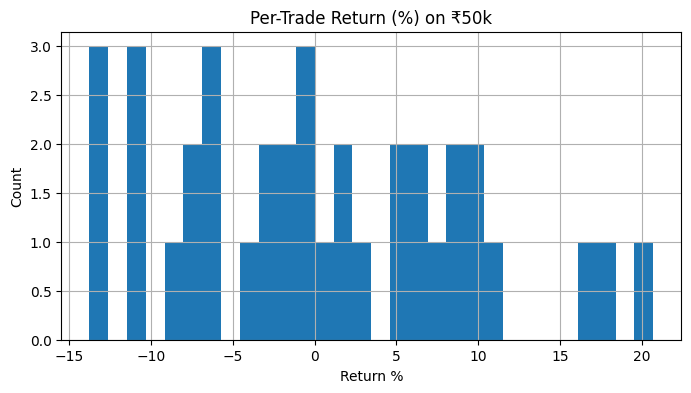

outcome
TIME       16
SL         12
TP          6
NOENTRY     3
Name: count, dtype: int64


In [14]:

if not trades.empty:
    # Histogram of per-trade returns
    import matplotlib.pyplot as plt
    plt.figure(figsize=(8,4))
    trades["ret_pct_on_50k"].hist(bins=30)
    plt.title("Per-Trade Return (%) on ₹50k")
    plt.xlabel("Return %"); plt.ylabel("Count")
    plt.show()

    # Outcome counts
    counts = trades["outcome"].value_counts()
    print(counts)
